In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm, feature_selection, linear_model, model_selection, metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import matplotlib.pylab as plb
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv('big_clean_dataset.csv').drop(columns='Unnamed: 0')

In [3]:
df.head(2)

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,0,11,0,738,1307,0,0,10014,0,0,0,0,0,0,2,81,1654656.0,181
1,0,11,0,738,1308,0,0,10014,0,0,0,0,0,0,2,81,1069162.0,263


In [4]:
# check whether dataframe has some empty string cell or None values
def check_empty(df):
    for col in df.select_dtypes(include='object'):
        if df[col].str.strip().isna().any():
            print(f"Column {col} contains None values")
        if df[col].str.strip().eq('').any():
            print(f"Column {col} contains empty values")
        
check_empty(df)

In [5]:
# build liner model
def bulid_liner_model(df, target_col, features, step=1, ranking=1):
    # choose numerical columns as a new dataframe
    df_model = df.select_dtypes(include=[np.number]).copy()
    # convert columns name to a list
    feature_cols = df_model.columns.values.tolist()
    # remove the Inprice column
    feature_cols.remove(target_col)
    XO = df_model[feature_cols]
    YO = df_model[target_col]
    # choose feature which are important in the prediction
    estimator = svm.SVR(kernel="linear")
    # 5 means no matter how many featrue as the input, only five most important parameters are left
    # 1 means after one iteration, exclude one least important featrue
    selector = feature_selection.RFE(estimator, n_features_to_select=features, step=step)
    selector = selector.fit(XO, YO)

    # From the ranking you can select your predictors with rank 1
    # Model 1; let us select the folowing features as predictors:
    select_features = np.array(feature_cols)[selector.ranking_ == ranking].tolist()

    # training the liner model
    X = df[select_features]
    Y = df[target_col]
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
    lm = linear_model.LinearRegression()
    lm.fit(trainX, trainY)


    print("R squared for the training data is {:4.3f}".format(lm.score(trainX, trainY)))
    print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))
    return lm, X, Y

In [6]:
# Using Correlation-based feature selection select high relation features
def select_related_feature(df, target, k_num):
    X = df.drop(target, axis=1)
    y = df[target]
    selector = SelectKBest(score_func=f_regression, k=k_num)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    return selected_features

# Modify the feature sum in order to change the model accuracy

In [7]:
target = 'SALE PRICE'
# select_features = select_related_feature(df_label, target, 7)
select_features = select_related_feature(df, target, 10)

In [8]:
df_train = df[select_features]
df_train = pd.concat([df_train, df[target]], axis=1)

In [9]:
lm1, X1, Y1 = bulid_liner_model(df_train, target, 200, 50)

R squared for the training data is 0.302
Score against test data: 0.287


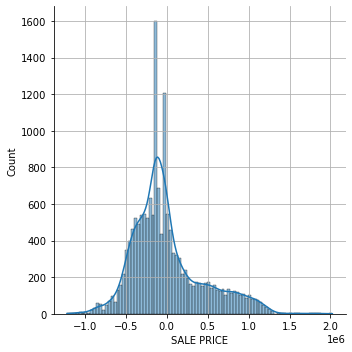

In [10]:
pred_y = lm1.predict(X1)
res = Y1 - pred_y
sns.displot(res, kde=True)
plt.grid()

In [11]:
from sklearn.model_selection import KFold, cross_val_score
crossvalidation = KFold(10,shuffle=True, random_state=0)

sr=cross_val_score(lm1, X1, Y1,scoring='r2',cv=crossvalidation,n_jobs=-1)

print("X validation r2 score for Linear regression: {:5.4f}".format(np.mean(sr)))

X validation r2 score for Linear regression: 0.2968


In [12]:
r2_score(Y1, pred_y)

0.2990478812851546